<a href="https://colab.research.google.com/github/deepenmi/pyTorchPractice/blob/master/CNN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scs.ryerson.ca



In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms


# GPU / CPU selection

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Loader


In [4]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8139174.86it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 121716.90it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2007299.37it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 46801.94it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

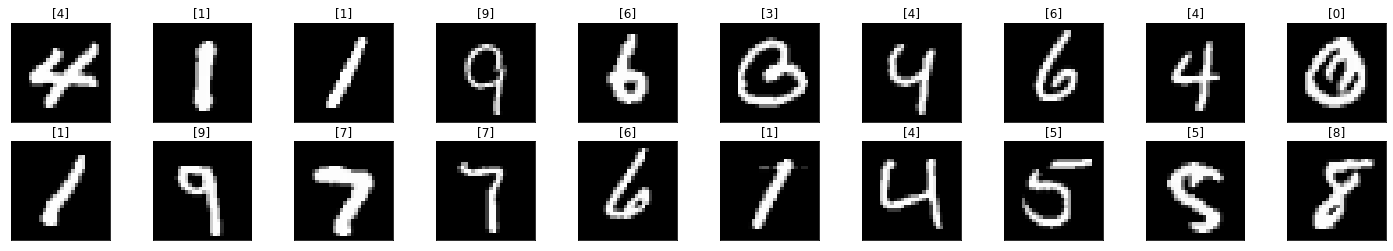

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

# Convolution Neural Network Definition

In [0]:
class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    # Convolution Layers
    self.conv1 = nn.Conv2d(1, 20, 5, 1)      # no. of input channels, no. of output channels, kernel size, stride length
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    # Fully Connected Layers
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x 


In [8]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 12
running_loss_history = []
running_corrects_history = []

val_running_loss_history=[]
val_running_corrects_history=[]

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  print(e)
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    running_loss+=loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_corrects += torch.sum(val_preds == val_labels.data)
        val_running_loss+=val_loss.item()

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('training loss: {:.4f}, accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item())) 
    print('Validation loss: {:.4f}, accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

0
training loss: 0.5038, accuracy: 87.3483
Validation loss: 0.1492, accuracy: 95.7500
1
training loss: 0.1235, accuracy: 96.3183
Validation loss: 0.0802, accuracy: 97.5100
2
training loss: 0.0815, accuracy: 97.5467
Validation loss: 0.0615, accuracy: 98.2000
3
training loss: 0.0638, accuracy: 98.0783
Validation loss: 0.0563, accuracy: 98.2500
4
training loss: 0.0524, accuracy: 98.4233
Validation loss: 0.0398, accuracy: 98.7500
5
training loss: 0.0450, accuracy: 98.5750
Validation loss: 0.0364, accuracy: 98.8200
6
training loss: 0.0387, accuracy: 98.8200
Validation loss: 0.0333, accuracy: 98.8800
7
training loss: 0.0340, accuracy: 98.9067
Validation loss: 0.0346, accuracy: 98.9100
8
training loss: 0.0302, accuracy: 99.0733
Validation loss: 0.0363, accuracy: 98.8600
9
training loss: 0.0274, accuracy: 99.1633
Validation loss: 0.0277, accuracy: 99.0900
10
training loss: 0.0245, accuracy: 99.2467
Validation loss: 0.0286, accuracy: 98.9800
11
training loss: 0.0217, accuracy: 99.3350
Validatio

# Training and Validation Loss


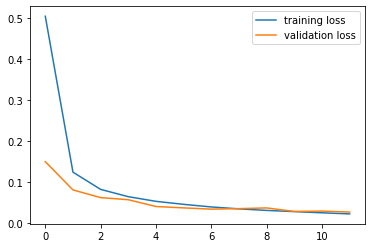

In [11]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()

# Training and Validation Accuracy

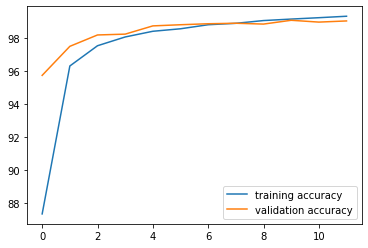

In [12]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history,label='validation accuracy')
plt.legend()

In [15]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
images_ = images.view(images.shape[0], -1)
outputs = model(images_)
_, preds = torch.max(outputs,1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))

RuntimeError: ignored